# Análisis de tarifas de Megaline

## Tabla de contenidos

* [Introducción](#intro) 
* [Objetivos](#objetivos)
* [Preprocesamiento de  datos](#data_review)
* [Análisis exploratorio de datos](#EDA)
* [Prueba de hipótesis](#hypotheses)
* [Conclusiones](#end)


## Introducción<a id='intro'></a>

Megaline es una operadora de telecomunicaciones. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para ajustar el presupuesto de publicidad.

En este proyecto se realizó un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Se analizaron los datos de 500 clientes de Megaline para responder las siguientes preguntas:

1. ¿Quiénes son y dónde se encuentran los clientes?
2. ¿Qué tarifa usan los clientes, la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018? 

## Objetivos<a id='objetivos'></a>

1. Analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.


 

## Preprocesamiento de datos <a id='data_review'></a>

In [198]:
# Importa liberías

import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st
import datetime
from matplotlib import pyplot as plt

**Estudio general de la información** 

In [199]:
# Carga de datos

calls = pd.read_csv("/datasets/megaline_calls.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
users = pd.read_csv("/datasets/megaline_users.csv")

*Preprocesamiento de datos de la variable "llamadas"* 

In [200]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [201]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [202]:
calls.describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


*Observaciones:*

1. La variable "user_id" tiene como tipo de dato "int64". Esta no es una variable sobre la cual se van a realizar cálculos. Por lo tanto, sería conveniente transformarla a "string".

2. La variable "call_date" no se encuentra almacenada como tipo de dato de fecha.

3. Exiten muchos valores de duración de llamadas igual a cero. Estas podrían ser llamadas perdidas. Investigaremos el número total de llamadas con duración cero minutos para comprender el impacto que podrían tener estos valores en el análisis.   

In [203]:
# Funciones de preprocesamiento de datos 

def change_data_type(variable,colunm_name,data_type):
    
    """
    
    Changes the data type for any selected pandas column.
    
    """
    
    variable[colunm_name] = variable[colunm_name].astype(data_type)
    
    print(variable.info())

def change_datetime_format(variable,colunm_name,format):
    
    """
    
    Changes the datetime forma type for any selected pandas column.
    
    """
    
    variable[colunm_name] = pd.to_datetime(variable[colunm_name], format=format)
    
    print(variable.info())

def percentage_zeros(variable,query_zero):
    
    """
    
    Calculates the percentage of absent values for any selected pandas column.
    
    """
    
    zero_calls = len(variable.query(query_zero))
    total_calls = len(variable)
    percentage_zero_calls = (zero_calls/total_calls)*100
    return percentage_zero_calls
        
def data_fill(variable, colunm_name, condition_value, query_nan):
    
    """
    
    Fills with floating NaN any pandas column given a condition.
    
    """
    
    variable.loc[variable[colunm_name] == condition_value, colunm_name] = np.NaN
    
    print(variable.info())
    print(variable.query(query_nan))

def year_month_day(variable,colunm_name):
    
    """
    
    Adds year, month and day columns to a dataframe.
    
    """
    
    variable['year'] = pd.DatetimeIndex(variable[colunm_name]).year
    variable['month'] = pd.DatetimeIndex(variable[colunm_name]).month
    variable['day'] = pd.DatetimeIndex(variable[colunm_name]).day
    
    print(variable.info())

In [204]:
change_data_type(calls,"user_id","string")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  string 
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), object(2), string(1)
memory usage: 4.2+ MB
None


In [205]:
change_datetime_format(calls,"call_date","%Y-%m-%d")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  string        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1), string(1)
memory usage: 4.2+ MB
None


In [206]:
calls.describe()

,duration
count,137735.000000
mean,6.745927
std,5.839241
min,0.000000
25%,1.290000
50%,5.980000
75%,10.690000
max,37.600000


In [207]:
percentage_zeros(calls,'duration == 0')

19.482339274694162

El porcentaje de llamadas de duración cero minutos es alto (19.48 %). Esto tendrá un impacto significativo en los análisis si se incluyen estos datos en cualquier cálculo posterior. Por lo tanto, los mismos se transformarán a valores ausentes "NaN" de tipo "float", sobre los cuales se puede operar sin afectar los resultados. Adicionalmente, esto permite conservar el resto de datos, los cuales se perderían si eliminamos los registros que tienen valor cero de duración de llamada.     

In [208]:
data_fill(calls, "duration", 0, "duration.isna()")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  string        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   110901 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1), string(1)
memory usage: 4.2+ MB
None
              id user_id  call_date  duration
19        1001_4    1001 2018-12-05       NaN
25       1001_13    1001 2018-12-24       NaN
31       1001_30    1001 2018-10-17       NaN
32       1001_31    1001 2018-11-03       NaN
34       1001_35    1001 2018-12-21       NaN
...          ...     ...        ...       ...
137714  1499_183    1499 2018-11-10       NaN
137715  1499_184    1499 2018-09-15       NaN
137720  1499_189    1499 2018-12-27       NaN
137722  1499_191    1499 2018-12-24       NaN
137725  1

In [209]:
len(calls.query("duration.isna()"))

26834

In [210]:
calls.describe()

,duration
count,110901.000000
mean,8.378196
std,5.354567
min,0.010000
25%,4.150000
50%,7.710000
75%,11.820000
max,37.600000


Como podemos apreciar en la última tabla de estadísticas generales, el no considerar el 19.48 % de los datos correspondientes a cero minutos de duración de llamadas cambia la media de la distribución que pasó de 6.75 a 8.39 minutos. Es decir, estos valores, que en la práctica no corresponden a llamadas efectivamente realizadas (variable en análisis), distorsionaban la distribución de los datos.

*Preprocesamiento de datos de la variable internet* 

In [211]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [212]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [213]:
internet.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


*Observaciones:*

1. Esta variable presenta los mismos problemas que la variable "calls". Por lo tanto, se aplicarán las mismas funciones para el preprocesamiento.
2. Los datos se muestran en la unidad de "MB", no obstante las tarifas de los planes se calculan en "GB". Por lo tanto, se tranformarán las unidadaes y se realizará el respectivo cambio de nombre de la columna.   

In [214]:
change_data_type(internet,"user_id","string")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  string 
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), object(2), string(1)
memory usage: 3.2+ MB
None


In [215]:
change_datetime_format(internet,"session_date","%Y-%m-%d")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  string        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1), string(1)
memory usage: 3.2+ MB
None


In [216]:
percentage_zeros(internet,'mb_used == 0')

13.11423801574052

In [217]:
data_fill(internet, "mb_used", 0, "mb_used.isna()")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  string        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       91078 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1), string(1)
memory usage: 3.2+ MB
None
              id user_id session_date  mb_used
1       1000_204    1000   2018-12-31      NaN
14       1001_26    1001   2018-09-17      NaN
16       1001_28    1001   2018-10-17      NaN
34       1001_54    1001   2018-09-02      NaN
43       1001_77    1001   2018-10-31      NaN
...          ...     ...          ...      ...
104797  1499_192    1499   2018-09-19      NaN
104804  1499_199    1499   2018-12-09      NaN
104816  1499_211    1499   2018-09-26      NaN
104817  1499_212    1499   

In [218]:
# Cambio de unidad de "MB" a "GB" y de nombre de columna

internet["mb_used"] = internet["mb_used"]/1024
internet.rename(columns = {'mb_used':'gb_used'}, inplace = True)
internet

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,0.087754
1,1000_204,1000,2018-12-31,NaN
2,1000_379,1000,2018-12-28,0.644922
3,1000_413,1000,2018-12-26,0.264639
4,1000_442,1000,2018-12-27,0.859590
...,...,...,...,...
104820,1499_215,1499,2018-10-20,0.212949
104821,1499_216,1499,2018-12-30,0.297578
104822,1499_217,1499,2018-09-22,0.285889
104823,1499_218,1499,2018-12-07,NaN


*Preprocesamiento de datos de la variable mensajes*

In [219]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [220]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


*Observaciones:*

1. Se aplicarán las funciones de preprocesamiento para el cambio de tipo de dato de las variables "user_id" y "message_date".  

In [221]:
change_data_type(messages,"user_id","string")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  string
 2   message_date  76051 non-null  object
dtypes: object(2), string(1)
memory usage: 1.7+ MB
None


In [222]:
change_datetime_format(messages,"message_date","%Y-%m-%d")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  string        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1), string(1)
memory usage: 1.7+ MB
None


In [223]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


*Observaciones:*

* El dataframe "plans" es informativo, por lo tanto no se lo preprocesará.

In [224]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


*Preprocesamiento de datos de la variable usuarios*

In [225]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [226]:
users.tail()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN
499,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN


In [227]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Observaciones:

1. Se aplicarán las funciones de preprocesamiento para el cambio de tipo de dato de las variables "user_id" y "reg_date".
2. El campo "city" proporciona valores de cuidad, área, y estado. Para fines de este estudio, es conveniente extraer el dato de estado y agregarlo a otra colunma que llamaremos "state". Adicionalmente, se debe renombrar la columna "city" por "location" para ser más precisos en la descripcióm del campo. 

In [228]:
change_data_type(users,"user_id","string")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    string
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(1), object(6), string(1)
memory usage: 31.4+ KB
None


In [229]:
change_datetime_format(users,"reg_date","%Y-%m-%d")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    string        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(5), string(1)
memory usage: 31.4+ KB
None


In [230]:
# Cambio de nombre de columna

users.rename(columns = {'city':'location'}, inplace = True)
users.head(50) #se aplica el head() a 50 filas para detectar las posibles expresiones del campo "locations".

,user_id,first_name,last_name,age,location,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


In [231]:
# Extracción del dato de estado


users["state"] = users["location"].str.extract(r'(\s\D\D[ -])')
users["state"].str.strip()
users["state"] = users["state"].str.rstrip('-')
users.head(50)

,user_id,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,WA
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN,TX
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,CA
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN,MI
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,FL
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN,CA


In [232]:
(users["plan"]=="surf").value_counts()

True     339
False    161
Name: plan, dtype: int64

In [233]:
(users["plan"]=="ultimate").value_counts()

False    339
True     161
Name: plan, dtype: int64

Como siguiente paso del procesamiento de datos, se creará nuevos dataframes que contengan (por tipo de plan) la siguiente información de cada usuario:

* El número de llamadas realizadas y minutos utilizados al mes. Las llamadas son de tipo flotante y tienen decimales en la duración, está variable será redondeada.
* La cantidad de los SMS enviados por mes.
* El volumen de datos por mes.
* Los ingresos mensuales por usuario.
* Su ubicación.

Sobre estos dataframes, se trabajarán las preguntas de investigación.

In [234]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


*Cálculo del número de llamadas realizadas y minutos utilizados al mes de cada usuario*

In [235]:
year_month_day(calls,'call_date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  string        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   110901 non-null  float64       
 4   year       137735 non-null  int64         
 5   month      137735 non-null  int64         
 6   day        137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1), string(1)
memory usage: 7.4+ MB
None


In [236]:
calls.head()

,id,user_id,call_date,duration,year,month,day
0,1000_93,1000,2018-12-27,8.52,2018,12,27
1,1000_145,1000,2018-12-27,13.66,2018,12,27
2,1000_247,1000,2018-12-27,14.48,2018,12,27
3,1000_309,1000,2018-12-28,5.76,2018,12,28
4,1000_380,1000,2018-12-30,4.22,2018,12,30


In [237]:
# Calcula el total de minutos usados por cada cliente 

monthly_minutes = calls.pivot_table(index=['user_id'], columns='month',
values='duration', aggfunc='sum')

In [238]:
monthly_minutes

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.83
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.14,297.69,374.11,404.59,392.93
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.13,359.76,363.24
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1041.00
1004,NaN,NaN,NaN,NaN,181.58,261.32,358.45,334.86,284.60,341.63,452.98,403.53
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.46,578.03,337.45,467.47
1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.62,389.94,301.16,291.88,278.61
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.53


In [239]:
monthly_minutes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, 1000 to 1499
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       6 non-null      float64
 1   2       15 non-null     float64
 2   3       35 non-null     float64
 3   4       71 non-null     float64
 4   5       104 non-null    float64
 5   6       141 non-null    float64
 6   7       179 non-null    float64
 7   8       230 non-null    float64
 8   9       277 non-null    float64
 9   10      337 non-null    float64
 10  11      403 non-null    float64
 11  12      460 non-null    float64
dtypes: float64(12)
memory usage: 48.9+ KB


In [240]:
monthly_minutes.describe()

month,1,2,3,4,5,6,7,8,9,10,11,12
count,6.000000,15.000000,35.000000,71.000000,104.000000,141.000000,179.000000,230.000000,277.000000,337.000000,403.000000,460.000000
mean,186.388333,345.779333,302.306571,327.685493,386.147885,396.740284,420.053520,395.339087,402.148628,419.041246,413.120099,451.482696
std,109.448090,225.740738,195.697623,202.133187,217.174407,194.555140,238.613746,216.230087,207.724167,211.993325,215.696099,231.754872
min,14.730000,36.820000,20.630000,15.690000,15.140000,12.500000,13.950000,3.900000,1.200000,0.000000,0.000000,8.730000
25%,122.695000,236.250000,140.045000,177.005000,233.042500,261.320000,282.165000,244.420000,247.970000,268.480000,265.300000,296.537500
50%,221.425000,287.170000,287.750000,301.260000,387.385000,391.130000,418.490000,374.030000,406.810000,423.120000,402.080000,426.570000
75%,274.442500,454.310000,408.340000,463.025000,528.792500,512.080000,548.020000,519.517500,524.170000,544.050000,552.625000,580.995000
max,278.850000,769.020000,739.050000,991.240000,995.630000,975.620000,1123.110000,1208.600000,1159.290000,1163.310000,1234.570000,1431.220000


In [241]:
# Calcula el número de llamadas mensuales por cada cliente 

monthly_calls = calls.pivot_table(index=['user_id'], columns='month',
values='duration', aggfunc='count')

In [242]:
monthly_calls.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,38.0,47.0,49.0,46.0
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,48.0,38.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.0
1004,NaN,NaN,NaN,NaN,19.0,33.0,45.0,42.0,32.0,47.0,45.0,43.0


In [243]:
monthly_calls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, 1000 to 1499
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       6 non-null      float64
 1   2       15 non-null     float64
 2   3       35 non-null     float64
 3   4       71 non-null     float64
 4   5       104 non-null    float64
 5   6       141 non-null    float64
 6   7       179 non-null    float64
 7   8       230 non-null    float64
 8   9       277 non-null    float64
 9   10      337 non-null    float64
 10  11      403 non-null    float64
 11  12      460 non-null    float64
dtypes: float64(12)
memory usage: 48.9+ KB


In [244]:
monthly_calls.describe()

month,1,2,3,4,5,6,7,8,9,10,11,12
count,6.000000,15.000000,35.000000,71.000000,104.000000,141.000000,179.000000,230.000000,277.000000,337.000000,403.000000,460.000000
mean,22.166667,41.933333,37.428571,39.507042,45.932692,47.205674,50.106145,47.339130,47.935018,50.210682,49.302730,53.621739
std,12.998718,26.871298,25.400655,23.884767,25.813470,22.624424,27.955923,25.384342,24.406493,25.132627,25.162609,26.832904
min,2.000000,4.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,2.000000
25%,15.000000,27.500000,16.000000,21.000000,27.000000,30.000000,32.000000,31.000000,31.000000,32.000000,32.500000,36.000000
50%,25.000000,36.000000,37.000000,38.000000,45.000000,46.000000,50.000000,47.000000,47.000000,50.000000,48.000000,51.000000
75%,32.750000,58.000000,48.000000,56.000000,64.000000,61.000000,65.000000,61.000000,62.000000,65.000000,65.000000,69.000000
max,34.000000,88.000000,99.000000,109.000000,120.000000,114.000000,137.000000,150.000000,150.000000,146.000000,146.000000,167.000000


*Cantidad de los SMS enviados por mes por cada usuario*

In [245]:
year_month_day(messages,'message_date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  string        
 2   message_date  76051 non-null  datetime64[ns]
 3   year          76051 non-null  int64         
 4   month         76051 non-null  int64         
 5   day           76051 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1), string(1)
memory usage: 3.5+ MB
None


In [246]:
messages.head()

,id,user_id,message_date,year,month,day
0,1000_125,1000,2018-12-27,2018,12,27
1,1000_160,1000,2018-12-31,2018,12,31
2,1000_223,1000,2018-12-31,2018,12,31
3,1000_251,1000,2018-12-27,2018,12,27
4,1000_255,1000,2018-12-26,2018,12,26


In [247]:
# Calcula el número de mensajes mensuales por cada cliente 

monthly_sms = messages.pivot_table(index=['user_id'], columns='month',
values='message_date', aggfunc='count')

In [248]:
monthly_sms.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,44.0,53.0,36.0,44.0
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,32.0,41.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
1004,NaN,NaN,NaN,NaN,7.0,18.0,26.0,25.0,21.0,24.0,25.0,31.0


In [249]:
monthly_sms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402 entries, 1000 to 1497
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       4 non-null      float64
 1   2       11 non-null     float64
 2   3       23 non-null     float64
 3   4       52 non-null     float64
 4   5       77 non-null     float64
 5   6       111 non-null    float64
 6   7       138 non-null    float64
 7   8       181 non-null    float64
 8   9       222 non-null    float64
 9   10      278 non-null    float64
 10  11      329 non-null    float64
 11  12      380 non-null    float64
dtypes: float64(12)
memory usage: 40.8+ KB


In [250]:
monthly_sms.describe()

month,1,2,3,4,5,6,7,8,9,10,11,12
count,4.000000,11.000000,23.000000,52.000000,77.000000,111.000000,138.000000,181.000000,222.000000,278.000000,329.000000,380.000000
mean,20.750000,23.545455,25.826087,25.634615,36.103896,34.531532,37.739130,40.850829,41.563063,43.888489,42.759878,50.186842
std,14.384598,21.006493,21.061926,22.853351,31.336705,29.766919,29.847619,32.208778,30.579517,34.518323,32.209964,36.941933
min,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000
25%,16.250000,9.500000,9.500000,9.000000,14.000000,11.500000,17.000000,15.000000,18.000000,18.250000,19.000000,24.000000
50%,22.000000,15.000000,21.000000,19.500000,27.000000,28.000000,30.000000,35.000000,34.000000,36.000000,35.000000,42.000000
75%,26.500000,27.500000,35.000000,34.500000,51.000000,49.000000,52.750000,60.000000,57.750000,59.750000,62.000000,70.000000
max,37.000000,67.000000,72.000000,120.000000,149.000000,143.000000,164.000000,156.000000,155.000000,224.000000,180.000000,266.000000


*Cálculo del volumen de datos por mes*

In [251]:
internet.head()

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,0.087754
1,1000_204,1000,2018-12-31,NaN
2,1000_379,1000,2018-12-28,0.644922
3,1000_413,1000,2018-12-26,0.264639
4,1000_442,1000,2018-12-27,0.859590


In [252]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  string        
 2   session_date  104825 non-null  datetime64[ns]
 3   gb_used       91078 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1), string(1)
memory usage: 3.2+ MB


In [253]:
year_month_day(internet,'session_date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  string        
 2   session_date  104825 non-null  datetime64[ns]
 3   gb_used       91078 non-null   float64       
 4   year          104825 non-null  int64         
 5   month         104825 non-null  int64         
 6   day           104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1), string(1)
memory usage: 5.6+ MB
None


In [254]:
internet.head()

,id,user_id,session_date,gb_used,year,month,day
0,1000_13,1000,2018-12-29,0.087754,2018,12,29
1,1000_204,1000,2018-12-31,NaN,2018,12,31
2,1000_379,1000,2018-12-28,0.644922,2018,12,28
3,1000_413,1000,2018-12-26,0.264639,2018,12,26
4,1000_442,1000,2018-12-27,0.859590,2018,12,27


In [255]:
# Calcula el volumen de datos mensuales por cada cliente 

monthly_data = internet.pivot_table(index=['user_id'], columns='month',
values='gb_used', aggfunc='sum')

In [256]:
monthly_data.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.856904
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.756982,13.002754,21.807119,18.070605,18.915215
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.398447,18.891680,14.058828
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.410293
1004,NaN,NaN,NaN,NaN,6.39376,20.188301,23.942012,27.325918,18.410859,14.200811,21.338652,20.887979


In [257]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 1000 to 1499
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       6 non-null      float64
 1   2       16 non-null     float64
 2   3       35 non-null     float64
 3   4       70 non-null     float64
 4   5       105 non-null    float64
 5   6       142 non-null    float64
 6   7       179 non-null    float64
 7   8       230 non-null    float64
 8   9       279 non-null    float64
 9   10      339 non-null    float64
 10  11      408 non-null    float64
 11  12      468 non-null    float64
dtypes: float64(12)
memory usage: 49.7+ KB


In [258]:
monthly_data.describe()

month,1,2,3,4,5,6,7,8,9,10,11,12
count,6.000000,16.000000,35.000000,70.000000,105.000000,142.000000,179.000000,230.000000,279.000000,339.000000,408.000000,468.000000
mean,6.090835,14.008255,14.698754,13.082658,14.464372,15.165126,16.340540,16.922931,16.374561,17.197056,16.245613,17.805420
std,3.731197,6.535217,9.533656,8.092314,7.538466,7.147865,7.835751,8.010884,6.887013,7.421668,7.320619,8.061675
min,1.284521,0.585723,1.218779,0.090146,0.126797,0.997393,0.111074,0.604443,0.399834,0.618203,0.234375,0.090508
25%,3.021865,9.601816,6.515225,6.766990,9.088193,11.902600,12.292979,12.425747,12.290313,12.386104,12.245205,13.498591
50%,7.181426,15.801528,15.637090,13.413481,14.498896,15.092246,15.917236,17.051128,16.561504,16.948730,16.498823,17.097974
75%,8.452300,19.616331,20.398086,18.582520,19.911523,18.462456,20.818677,20.790508,20.425132,20.781670,20.054480,21.477275
max,10.386367,21.092725,35.215859,36.876553,35.812783,37.018691,38.016689,50.595068,36.706084,45.770264,41.945889,69.269131


In [259]:
calls.head()

,id,user_id,call_date,duration,year,month,day
0,1000_93,1000,2018-12-27,8.52,2018,12,27
1,1000_145,1000,2018-12-27,13.66,2018,12,27
2,1000_247,1000,2018-12-27,14.48,2018,12,27
3,1000_309,1000,2018-12-28,5.76,2018,12,28
4,1000_380,1000,2018-12-30,4.22,2018,12,30


In [260]:
users.head()

,user_id,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,WA


In [261]:
monthly_minutes.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.83
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.14,297.69,374.11,404.59,392.93
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.13,359.76,363.24
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1041.00
1004,NaN,NaN,NaN,NaN,181.58,261.32,358.45,334.86,284.60,341.63,452.98,403.53


In [262]:
# Definición de función para cálculo de ingresos por tipo de plan y servicio usado

def revenue(pivot, plan, base_plan, overcharge):
    
    """"
    
    Calcula el ingreso de cada usuario por cada plan y servicio usado, incluyendo sobrecargos.
    
    """
    pivot_to_dataframe = pivot.reset_index().rename_axis(None, axis=1) #convierte la tabla pivot en un dataframe  
    pivot_to_dataframe = pd.merge(pivot_to_dataframe, users, on="user_id") # une las tablas en base a la columna "user_id"
    pivot_to_dataframe = pivot_to_dataframe[pivot_to_dataframe["plan"] == plan] #filtra el dataframe dependiendo del tipo de plan    
    pivot_to_dataframe[[1,2,3,4,5,6,7,8,9,10,11,12]] = (pivot_to_dataframe[[1,2,3,4,5,6,7,8,9,10,11,12]].fillna(0).apply(np.ceil)-base_plan) #preprocesa la tabla para los cálculos
    pivot_to_dataframe[[1,2,3,4,5,6,7,8,9,10,11,12]] = pivot_to_dataframe[[1,2,3,4,5,6,7,8,9,10,11,12]].applymap(lambda x: np.nan if x<=0 else x*overcharge) #calcula el ingreso por sobrecargo  
    revenue = pivot_to_dataframe.reset_index(drop=True)
    return revenue

In [263]:
# Ingreso mensual por concepto de llamadas por usuario plan "surf"

monthly_calls_charge_surf = revenue(monthly_minutes, "surf", 500, 0.03)
monthly_calls_charge_surf

,user_id,1,2,3,4,5,6,7,8,9,...,11,12,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,WA
1,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,NV
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.23,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,OK
3,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,WA
4,1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,NaN,NY
322,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN,NY
323,1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN,LA
324,1498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN,NY


In [264]:
# Ingreso mensual por concepto de mensajes por usuario plan "surf"

monthly_sms_charge_surf = revenue(monthly_sms, "surf", 50, 0.03)
monthly_sms_charge_surf

,user_id,1,2,3,4,5,6,7,8,9,...,11,12,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,WA
1,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,NV
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,OK
3,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,WA
4,1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,...,1.23,1.08,Londa,Jenkins,72,"Detroit-Warren-Dearborn, MI MSA",2018-05-24,surf,NaN,MI
266,1491,NaN,NaN,NaN,NaN,NaN,0.12,0.42,NaN,NaN,...,NaN,NaN,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,MI
267,1492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,NaN,OR
268,1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,NaN,NY


In [265]:
# Ingreso mensual por concepto de internet por usuario plan "surf"

monthly_data_charge_surf = revenue(monthly_data, "surf", 15, 10)
monthly_data_charge_surf

,user_id,1,2,3,4,5,6,7,8,9,...,11,12,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,40.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,WA
1,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,NaN,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,NV
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,120.0,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,OK
3,1004,NaN,NaN,NaN,NaN,NaN,60.0,90.0,130.0,40.0,...,70.0,60.0,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,WA
4,1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,10.0,...,30.0,NaN,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,NaN,NY
328,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,...,100.0,90.0,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN,NY
329,1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,NaN,20.0,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN,LA
330,1498,NaN,50.0,50.0,50.0,70.0,NaN,100.0,50.0,80.0,...,40.0,80.0,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN,NY


In [266]:
# Ingreso mensual por concepto de llamadas por usuario plan "Ultimate"

monthly_calls_charge_ultimate = revenue(monthly_minutes, "ultimate", 3000, 0.01)
monthly_calls_charge_ultimate

,user_id,1,2,3,4,5,6,7,8,9,...,11,12,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,GA
1,1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,CA
2,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,FL
3,1011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN,OH
4,1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaN,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Armand,Glenn,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaN,NY
151,1487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Elton,Simpson,18,"Cape Coral-Fort Myers, FL MSA",2018-08-16,ultimate,NaN,FL
152,1490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Shane,Cortez,42,"Sacramento–Roseville–Folsom, CA MSA",2018-01-20,ultimate,NaN,CA
153,1493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cicely,Wynn,18,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-06,ultimate,NaN,MA


In [267]:
# Ingreso mensual por concepto de mensajes por usuario plan "ultimate"

monthly_sms_charge_ultimate = revenue(monthly_sms, "ultimate", 1000, 0.01)
monthly_sms_charge_ultimate

,user_id,1,2,3,4,5,6,7,8,9,...,11,12,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,GA
1,1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,CA
2,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,FL
3,1011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN,OH
4,1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaN,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,1477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Magaly,Rivas,52,"Riverside-San Bernardino-Ontario, CA MSA",2018-08-24,ultimate,NaN,CA
128,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Elane,David,51,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-06-28,ultimate,NaN,OR
129,1482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Armand,Glenn,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaN,NY
130,1487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Elton,Simpson,18,"Cape Coral-Fort Myers, FL MSA",2018-08-16,ultimate,NaN,FL


In [268]:
# Ingreso mensual por concepto de internet por usuario plan "ultimate"

monthly_data_charge_ultimate = revenue(monthly_data, "ultimate", 30, 7)
monthly_data_charge_ultimate

,user_id,1,2,3,4,5,6,7,8,9,...,11,12,first_name,last_name,age,location,reg_date,plan,churn_date,state
0,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,GA
1,1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,14.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,CA
2,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,FL
3,1011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN,OH
4,1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaN,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,1482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Armand,Glenn,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaN,NY
153,1487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Elton,Simpson,18,"Cape Coral-Fort Myers, FL MSA",2018-08-16,ultimate,NaN,FL
154,1490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,42.0,...,NaN,112.0,Shane,Cortez,42,"Sacramento–Roseville–Folsom, CA MSA",2018-01-20,ultimate,NaN,CA
155,1493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cicely,Wynn,18,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-06,ultimate,NaN,MA


In [269]:
lst = [monthly_calls_charge_surf, 
            monthly_sms_charge_surf, monthly_data_charge_surf] #crea una lista pata concatenar dataframes
df_result = pd.concat(lst)#concatena los dataframes

In [270]:
lst = [monthly_calls_charge_surf, 
            monthly_sms_charge_surf, monthly_data_charge_surf] #crea una lista pata concatenar dataframes
df_result = pd.concat(lst)#concatena los dataframes
df_result = df_result.groupby(["user_id"]).agg({'state': 'first',
                       1: sum,
                       2: sum,      
                       3: sum,
                       4: sum,      
                       5: sum,
                       6: sum, 
                       7: sum, 
                       8: sum, 
                       9: sum, 
                       10: sum, 
                       11: sum,  
                       12: sum})  

df_result.reset_index(inplace=True)
df_result.rename(columns = {'index':'user_id'})
df_result[[1,2,3,4,5,6,7,8,9,10,11,12]] = df_result[[1,2,3,4,5,6,7,8,9,10,11,12]].applymap(lambda x: 20 if x==0 else x)

df_result                             

,user_id,state,1,2,3,4,5,6,7,8,9,10,11,12
0,1001,WA,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,70.09,40.0,40.00
1,1002,NV,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,40.0,20.00
2,1003,OK,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,136.23
3,1004,WA,20,20.0,20.0,20.0,20.0,60.0,90.0,130.0,40.0,20.00,70.0,60.00
4,1005,TX,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,20.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,1494,NY,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,10.0,2.58,30.0,20.00
329,1495,NY,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,80.0,122.37,100.0,90.00
330,1496,LA,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,20.00
331,1498,NY,20,50.0,50.0,50.0,70.0,20.0,100.0,50.0,80.0,60.00,40.0,80.00


In [271]:
# Función para cálculo de ingresos mensuales por tipo de plan

def final_revenue(calls,sms,data,basic_charge):
    
    """"
    
    Calcula el ingreso de cada usuario por cada plan incluyendo sobrecargos.
    
    """
    
    lst = [calls, sms, data] #crea una lista pata concatenar dataframes
    df_result = pd.concat(lst)#concatena los dataframes
    df_result = df_result.groupby(["user_id"]).agg({'state': 'first', 'plan': 'first', #agrupa por número de usuario, suma los valores de las columnas 1 a 12 y coloca la ubicación de usuario
                       1: sum,
                       2: sum,      
                       3: sum,
                       4: sum,      
                       5: sum,
                       6: sum, 
                       7: sum, 
                       8: sum, 
                       9: sum, 
                       10: sum, 
                       11: sum,  
                       12: sum})  
    df_result.reset_index(inplace=True) #coloca los números de usuario como una columna y restablece los índices 
    df_result.rename(columns = {'index':'user_id'}) #renombra la columna de usuario
    df_result[[1,2,3,4,5,6,7,8,9,10,11,12]] = df_result[[1,2,3,4,5,6,7,8,9,10,11,12]].applymap(lambda x: basic_charge if x==0 else x+basic_charge) #asigna los valores del pan básico
       
    return df_result

In [272]:
# Ingresos mensuales plan "surf"

monthly_revenue_surf = final_revenue(monthly_calls_charge_surf, 
            monthly_sms_charge_surf, monthly_data_charge_surf, 20)

monthly_revenue_surf

,user_id,state,plan,1,2,3,4,5,6,7,8,9,10,11,12
0,1001,WA,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,90.09,60.0,60.00
1,1002,NV,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,60.0,20.00
2,1003,OK,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,156.23
3,1004,WA,surf,20,20.0,20.0,20.0,20.0,80.0,110.0,150.0,60.0,20.00,90.0,80.00
4,1005,TX,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,40.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,1494,NY,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,40.0,30.0,22.58,50.0,20.00
329,1495,NY,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,100.0,142.37,120.0,110.00
330,1496,LA,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,40.0,20.00,20.0,40.00
331,1498,NY,surf,20,70.0,70.0,70.0,90.0,20.0,120.0,70.0,100.0,80.00,60.0,100.00


In [303]:
monthly_revenue_surf.describe()

,1,2,3,4,5,6,7,8,9,10,11,12
count,333.0,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,20.0,20.385405,21.781471,23.071862,26.298769,28.428559,35.343574,41.199489,42.110360,52.063393,51.982883,67.851141
std,0.0,3.965245,11.950400,15.173155,24.056215,27.299935,38.336132,46.993325,40.751258,51.747247,47.878173,67.019558
min,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
25%,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.930000
50%,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.390000,25.610000,50.000000
75%,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.930000,40.000000,50.000000,70.000000,70.000000,90.000000
max,20.0,70.000000,170.000000,150.000000,230.870000,240.000000,260.000000,380.000000,240.780000,330.000000,290.360000,588.660000


In [275]:
# Ingresos mensuales plan "ultimate"

monthly_revenue_ultimate = final_revenue(monthly_calls_charge_ultimate, 
                                     monthly_sms_charge_ultimate, monthly_data_charge_ultimate, 70)
monthly_revenue_ultimate

,user_id,state,plan,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,GA,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
1,1006,CA,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,84.0
2,1008,FL,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
3,1011,OH,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
4,1013,TN,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,1482,NY,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
153,1487,FL,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
154,1490,CA,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,133.0,112.0,119.0,70.0,182.0
155,1493,MA,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0


In [276]:
monthly_revenue_ultimate.describe()

,1,2,3,4,5,6,7,8,9,10,11,12
count,157.0,157.0,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,70.0,70.0,70.356688,70.401274,70.133758,70.490446,70.713376,71.292994,71.114650,71.560510,71.382166,73.165605
std,0.0,0.0,3.436256,4.060220,1.675982,4.763130,6.300235,8.455965,6.512284,10.739537,8.770240,14.320439
min,70.0,70.0,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
25%,70.0,70.0,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
50%,70.0,70.0,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
75%,70.0,70.0,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
max,70.0,70.0,112.000000,119.000000,91.000000,126.000000,126.000000,140.000000,119.000000,182.000000,154.000000,182.000000


In [277]:
# Matriz de ingresos de los dos planes

monthly_revenue = pd.concat([monthly_revenue_surf,monthly_revenue_ultimate], ignore_index=True)

monthly_revenue

,user_id,state,plan,1,2,3,4,5,6,7,8,9,10,11,12
0,1001,WA,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,90.09,60.0,60.00
1,1002,NV,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,60.0,20.00
2,1003,OK,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,156.23
3,1004,WA,surf,20,20.0,20.0,20.0,20.0,80.0,110.0,150.0,60.0,20.00,90.0,80.00
4,1005,TX,surf,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,40.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,1482,NY,ultimate,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.00,70.0,70.00
486,1487,FL,ultimate,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.00,70.0,70.00
487,1490,CA,ultimate,70,70.0,70.0,70.0,70.0,70.0,70.0,133.0,112.0,119.00,70.0,182.00
488,1493,MA,ultimate,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.00,70.0,70.00


**Conclusiones preprocesamiento:**

1. El preprocesamiento requirió en primer lugar del cambio de tipo de datos (a "string", formatos de fecha, etc.). 
2. Los pasos clave para este procesamiento fueron el aplicar los métodos "merge" y "concatenate" para unir tablas.
3. Un paso adicional importante para el preprocesamiento fue el uso de expresiones regulares para extraer los datos de ubicación ("state") de los usuarios.


## Análisis exploratorio de datos <a id='EDA'></a>

En esta sección, se describirá el comportamiento de los clientes. Adicionalmente, se encuentraran los minutos, SMS y volumen de datos que requieren los usuarios de cada tarifa por mes. Se calculará la media, la varianza y la desviación estándar. Finalmente, se trazarán histogramas y diagramas de cajas.

In [278]:
# Genera información mensual para analizar la cantidad de minutos, 
# SMS y volumen de datos por tipo de plan

def monthly_analysis_df(pivot,plan):
    
    """"
    
    Genera tablas para analizar minutos, SMS y volumen de datos por tipo de plan
    
    """
    pivot_to_dataframe = pivot.reset_index().rename_axis(None, axis=1) #convierte la tabla pivot en un dataframe  
    merged_tables = pd.merge(pivot_to_dataframe, users, on="user_id") #une las tablas en base a la columna "user_id"
    result = merged_tables[merged_tables["plan"] == plan] #selecciona el tipo de plan 
    result[[1,2,3,4,5,6,7,8,9,10,11,12]] = (result[[1,2,3,4,5,6,7,8,9,10,11,12]].fillna(0).apply(np.ceil)) #preprocesa el dataframe
    result = result.groupby(["user_id"]).agg({ #agrupa por número de usuario, suma los valores de las columnas 1 a 12 y coloca la ubicación de usuario
                       1: sum,
                       2: sum,      
                       3: sum,
                       4: sum,      
                       5: sum,
                       6: sum, 
                       7: sum, 
                       8: sum, 
                       9: sum, 
                       10: sum, 
                       11: sum,  
                       12: sum})
    
    result = result.sum(axis=0)
    
    return result

In [279]:
# Variables

plans = ['surf', 'ultimate']
pivots = [monthly_calls, monthly_minutes, monthly_sms, monthly_data]

monthly_calls.name = "calls"
monthly_minutes.name =  "minutes"
monthly_sms.name = "sms"
monthly_data.name = "data"


In [280]:
# Datos Mensuales

for pivot in pivots:
    for plan in plans:      
    
        analysis = monthly_analysis_df(pivot, plan)
        
        print(f"Monthly analystics {plan}-{pivot.name}")
        print(analysis)

Monthly analystics surf-calls
1        48.0
2       298.0
3       871.0
4      1985.0
5      3444.0
6      4675.0
7      6175.0
8      7480.0
9      9070.0
10    11513.0
11    13525.0
12    16793.0
dtype: float64
Monthly analystics ultimate-calls
1       85.0
2      331.0
3      439.0
4      820.0
5     1333.0
6     1981.0
7     2794.0
8     3408.0
9     4208.0
10    5408.0
11    6344.0
12    7873.0
dtype: float64
Monthly analystics surf-minutes
1        386.0
2       2532.0
3       7163.0
4      16646.0
5      29070.0
6      39546.0
7      51425.0
8      62801.0
9      75942.0
10     96270.0
11    113219.0
12    142459.0
dtype: float64
Monthly analystics ultimate-minutes
1       735.0
2      2663.0
3      3434.0
4      6659.0
5     11142.0
6     16467.0
7     23852.0
8     28243.0
9     35585.0
10    45124.0
11    53460.0
12    65466.0
dtype: float64
Monthly analystics surf-sms
1        21.0
2       108.0
3       351.0
4       870.0
5      1849.0
6      2454.0
7      3271.0
8      466

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [281]:
# Estadísticas generales

for pivot in pivots:
    for plan in plans:      
    
        analysis = monthly_analysis_df(pivot, plan)
        
        print(f"Descriptive statistics for {plan}-{pivot.name}")
        print(analysis.describe())
        

Descriptive statistics for surf-calls
count       12.000000
mean      6323.083333
std       5498.394054
min         48.000000
25%       1706.500000
50%       5425.000000
75%       9680.750000
max      16793.000000
dtype: float64
Descriptive statistics for ultimate-calls
count      12.000000
mean     2918.666667
std      2577.258386
min        85.000000
25%       724.750000
50%      2387.500000
75%      4508.000000
max      7873.000000
dtype: float64
Descriptive statistics for surf-minutes
count        12.000000
mean      53121.583333
std       46336.499125
min         386.000000
25%       14275.250000
50%       45485.500000
75%       81024.000000
max      142459.000000
dtype: float64
Descriptive statistics for ultimate-minutes
count       12.000000
mean     24402.500000
std      21587.264594
min        735.000000
25%       5852.750000
50%      20159.500000
75%      37969.750000
max      65466.000000
dtype: float64
Descriptive statistics for surf-sms
count       12.000000
mean      4084

Histogram for surf-calls


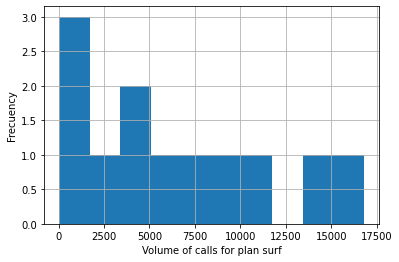

Histogram for ultimate-calls


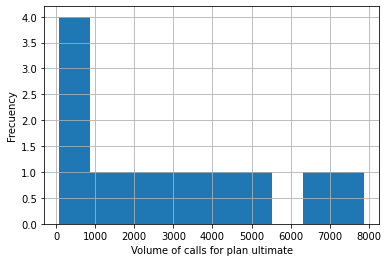

Histogram for surf-minutes


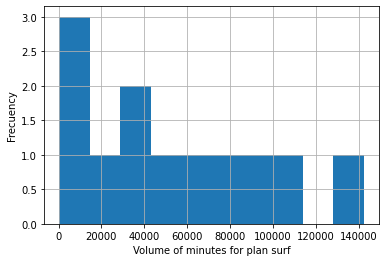

Histogram for ultimate-minutes


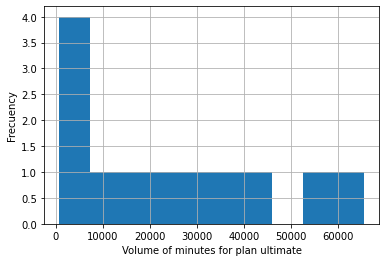

Histogram for surf-sms


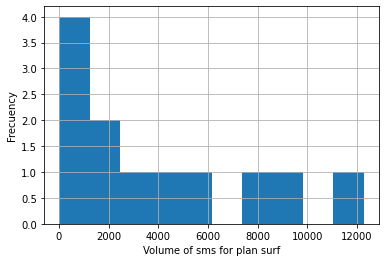

Histogram for ultimate-sms


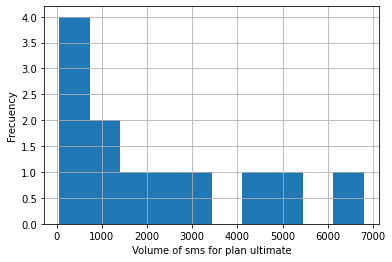

Histogram for surf-data


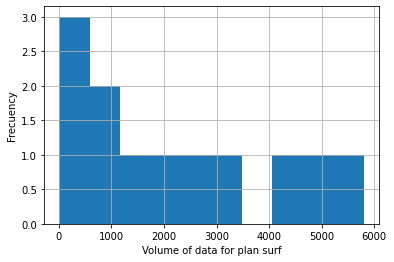

Histogram for ultimate-data


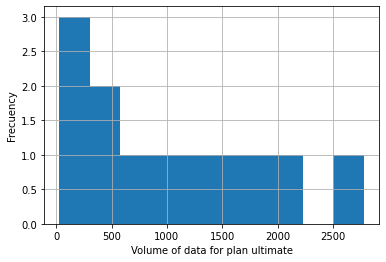

In [282]:
# Histogramas

for pivot in pivots:
    for plan in plans:      
    
        analysis = monthly_analysis_df(pivot, plan)
        
        print(f"Histogram for {plan}-{pivot.name}")
        analysis.hist()
        plt.xlabel(f"Volume of {pivot.name} for plan {plan}")
        plt.ylabel('Frecuency')
        plt.show()

Boxplot for surf-calls


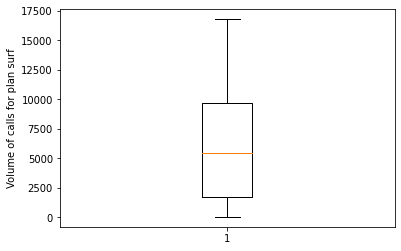

Boxplot for ultimate-calls


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


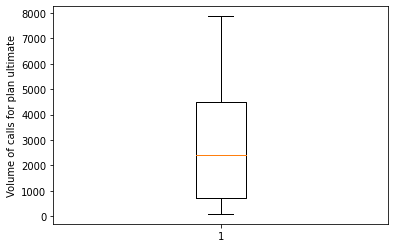

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Boxplot for surf-minutes


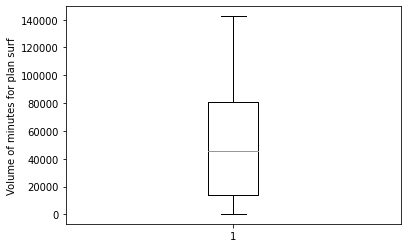

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Boxplot for ultimate-minutes


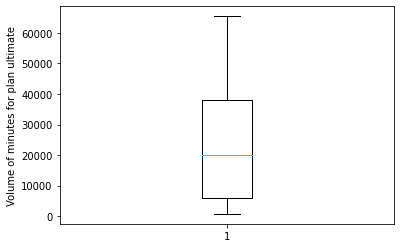

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Boxplot for surf-sms


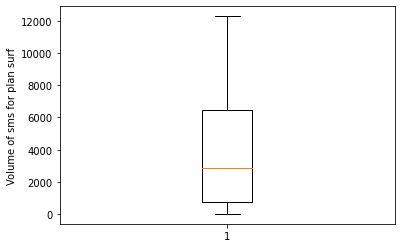

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Boxplot for ultimate-sms


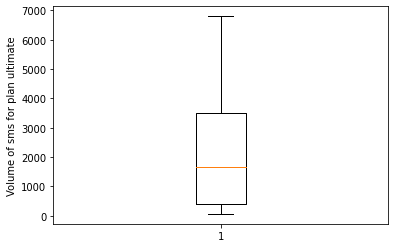

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Boxplot for surf-data


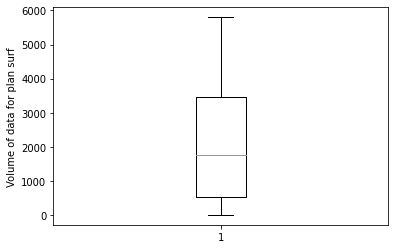

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Boxplot for ultimate-data


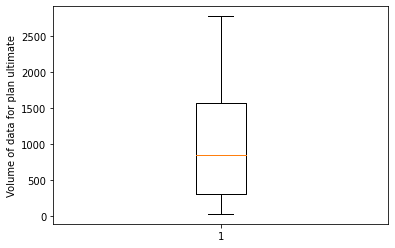

In [283]:
# Diagrama de cajas

for pivot in pivots:
    for plan in plans:      
    
        analysis = monthly_analysis_df(pivot, plan)
        
        print(f"Boxplot for {plan}-{pivot.name}")
        plt.figure()
        plt.boxplot(analysis)
        plt.ylabel(f"Volume of {pivot.name} for plan {plan}")
        plt.show()

*Observaciones*

1. Al parecer existen valores atípicos para todas las variables analizadas, y para los dos tipos de plan. En este sentido, se procederá con la confirmación estadística de la observación. 

In [284]:
# Genera tablas con información mensual para analizar la cantidad de minutos, 
# SMS y volumen de datos por tipo de plan para el análisis de anomalías

def analysis_df(pivot,plan):
    
    """"
    
    Genera tablas para analizar minutos, SMS y volumen de datos por tipo de plan
    
    """
    pivot_to_dataframe = pivot.reset_index().rename_axis(None, axis=1) #convierte la tabla pivot en un dataframe  
    merged_tables = pd.merge(pivot_to_dataframe, users, on="user_id") #une las tablas en base a la columna "user_id"
    result = merged_tables[merged_tables["plan"] == plan] #selecciona el tipo de plan 
    result[[1,2,3,4,5,6,7,8,9,10,11,12]] = (result[[1,2,3,4,5,6,7,8,9,10,11,12]].fillna(0).apply(np.ceil)) #preprocesa el dataframe
    result = result.groupby(["user_id"]).agg({ #agrupa por número de usuario, suma los valores de las columnas 1 a 12 y coloca la ubicación de usuario
                       1: sum,
                       2: sum,      
                       3: sum,
                       4: sum,      
                       5: sum,
                       6: sum, 
                       7: sum, 
                       8: sum, 
                       9: sum, 
                       10: sum, 
                       11: sum,  
                       12: sum})   
    return result

In [285]:
# Genera matrices para el análisis de anomalías

calls_surf = analysis_df(monthly_calls,"surf")
calls_ultimate = analysis_df(monthly_calls,"ultimate")
minutes_surf = analysis_df(monthly_minutes,"surf")
minutes_ultimate = analysis_df(monthly_minutes,"ultimate")
sms_surf = analysis_df(monthly_sms,"surf")
sms_ultimate = analysis_df(monthly_sms,"ultimate")
data_surf = analysis_df(monthly_data,"surf")
data_ultimate = analysis_df(monthly_data,"ultimate")

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [286]:
# La función asigna el valor de nan a valores extremos

def anomaly_handling(dataframe):
    vector = dataframe.stack() #convierte la matrix a vector
    Q1 = vector.quantile(0.25) #calcula el cuantile 0.25
    Q3 = vector.quantile(0.75) #calcula el cuantile 0.75
    IQR = Q3 -Q1 #calcula el rango intercuantil
    upper = Q3 + 1.5*IQR #calcula el límite superior de las anomalías
    dataframe = dataframe.applymap(lambda x:np.nan if x>upper else x) #asigna el valor de nan a valores extremos
    return dataframe

In [287]:
# Genera nuevos dataframes sin anomalías

calls_surf_revised = anomaly_handling(calls_surf)
calls_ultimate_revised = anomaly_handling(calls_ultimate)
minutes_surf_revised = anomaly_handling(minutes_surf)
minutes_ultimate_revised = anomaly_handling(minutes_ultimate)
sms_surf_revised = anomaly_handling(sms_surf)
sms_ultimate_revised = anomaly_handling(sms_ultimate)
data_surf_revised = anomaly_handling(data_surf)
data_ultimate_revised = anomaly_handling(data_ultimate)

In [288]:
# Suma en el eje de las columnas para comparar con el análisis inicial

calls_surf_revised = calls_surf_revised.sum(axis=0)
calls_ultimate_revised = calls_ultimate_revised.sum(axis=0)
minutes_surf_revised = minutes_surf_revised.sum(axis=0)
minutes_ultimate_revised = minutes_ultimate_revised.sum(axis=0)
sms_surf_revised = sms_surf_revised.sum(axis=0)
sms_ultimate_revised = sms_ultimate_revised.sum(axis=0)
data_surf_revised = data_surf_revised.sum(axis=0)
data_ultimate_revised = data_ultimate_revised.sum(axis=0)

In [289]:
# Variables revisadas

revised_dataframes =  [calls_surf_revised, calls_ultimate_revised, minutes_surf_revised, minutes_ultimate_revised,
                      sms_surf_revised, sms_ultimate_revised, data_surf_revised, data_ultimate_revised]

calls_surf_revised.name = "calls_surf_revised"
calls_ultimate_revised.name = "calls_ultimate_revised"
minutes_surf_revised.name = "minutes_surf_revised" 
minutes_ultimate_revised.name = "minutes_ultimate_revised"
sms_surf_revised.name = "sms_surf_revised"
sms_ultimate_revised.name = "sms_ultimate_revised"
data_surf_revised.name = "data_surf_revised"
data_ultimate_revised.name = "data_ultimate_revised"


*Análisis exploratorio con datos corregidos*

In [290]:
# Datos Mensuales

for dataframe in revised_dataframes:      
        
        print(f"Monthly analytics-{dataframe.name}")
        print(dataframe)

Monthly analytics-calls_surf_revised
1        48.0
2       298.0
3       871.0
4      1876.0
5      3204.0
6      4456.0
7      5497.0
8      6909.0
9      8581.0
10    10919.0
11    12685.0
12    14744.0
Name: calls_surf_revised, dtype: float64
Monthly analytics-calls_ultimate_revised
1       85.0
2      331.0
3      439.0
4      820.0
5     1235.0
6     1981.0
7     2328.0
8     2951.0
9     3629.0
10    4817.0
11    5272.0
12    6888.0
Name: calls_ultimate_revised, dtype: float64
Monthly analytics-minutes_surf_revised
1        386.0
2       2532.0
3       7163.0
4      15654.0
5      27125.0
6      37677.0
7      43949.0
8      57864.0
9      71952.0
10     90264.0
11    105424.0
12    121262.0
Name: minutes_surf_revised, dtype: float64
Monthly analytics-minutes_ultimate_revised
1       735.0
2      2663.0
3      3434.0
4      6659.0
5     10324.0
6     16467.0
7     19183.0
8     23719.0
9     31355.0
10    38528.0
11    43429.0
12    56410.0
Name: minutes_ultimate_revised, dtype: 

In [291]:
# Estadísticas generales

for dataframe in revised_dataframes:      
        
    print(f"Descriptive statistics for-{dataframe.name}")
    print(dataframe.describe())

Descriptive statistics for-calls_surf_revised
count       12.000000
mean      5840.666667
std       4993.033371
min         48.000000
25%       1624.750000
50%       4976.500000
75%       9165.500000
max      14744.000000
Name: calls_surf_revised, dtype: float64
Descriptive statistics for-calls_ultimate_revised
count      12.000000
mean     2564.666667
std      2200.019724
min        85.000000
25%       724.750000
50%      2154.500000
75%      3926.000000
max      6888.000000
Name: calls_ultimate_revised, dtype: float64
Descriptive statistics for-minutes_surf_revised
count        12.000000
mean      48437.666667
std       41260.675919
min         386.000000
25%       13531.250000
50%       40813.000000
75%       76530.000000
max      121262.000000
Name: minutes_surf_revised, dtype: float64
Descriptive statistics for-minutes_ultimate_revised
count       12.000000
mean     21075.500000
std      18034.513611
min        735.000000
25%       5852.750000
50%      17825.000000
75%      33148.

Histogram for-calls_surf_revised


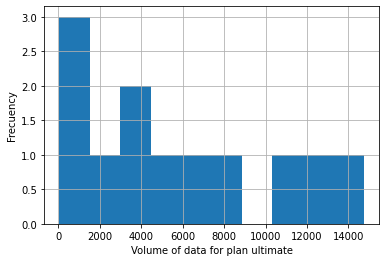

Histogram for-calls_ultimate_revised


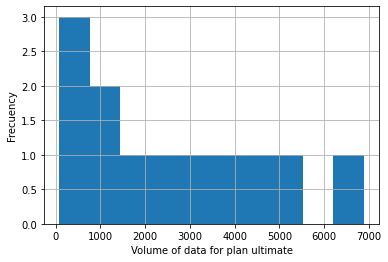

Histogram for-minutes_surf_revised


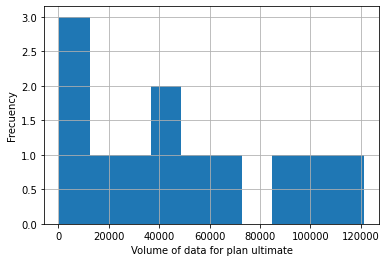

Histogram for-minutes_ultimate_revised


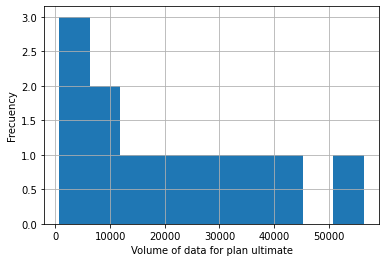

Histogram for-sms_surf_revised


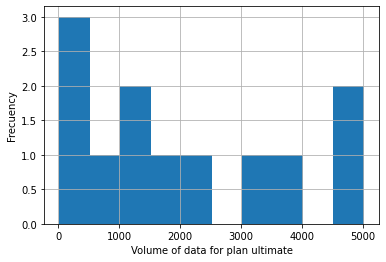

Histogram for-sms_ultimate_revised


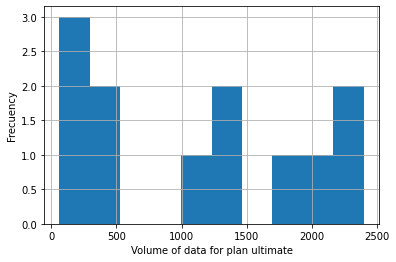

Histogram for-data_surf_revised


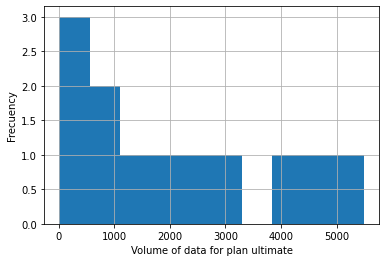

Histogram for-data_ultimate_revised


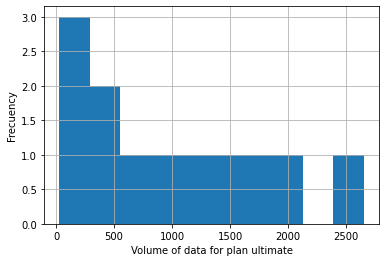

In [292]:
# Histogramas
       
for dataframe in revised_dataframes:      
        
    print(f"Histogram for-{dataframe.name}")
    dataframe.hist()
    plt.xlabel(f"Volume of {pivot.name} for plan {plan}")
    plt.ylabel('Frecuency')
    plt.show()

Boxplot for-calls_surf_revised


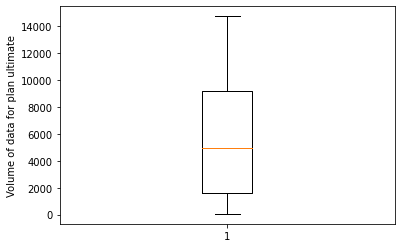

Boxplot for-calls_ultimate_revised


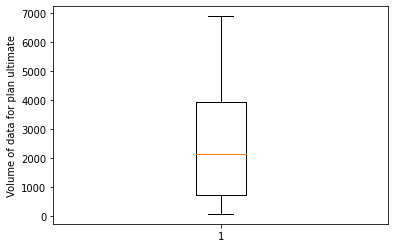

Boxplot for-minutes_surf_revised


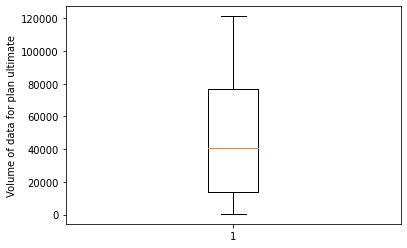

Boxplot for-minutes_ultimate_revised


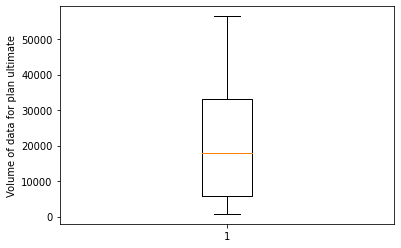

Boxplot for-sms_surf_revised


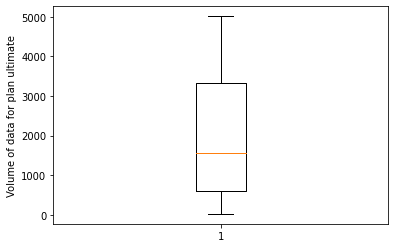

Boxplot for-sms_ultimate_revised


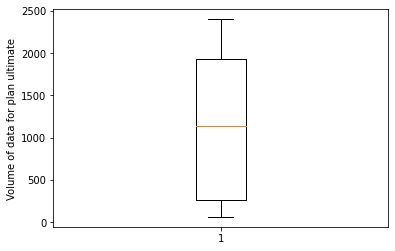

Boxplot for-data_surf_revised


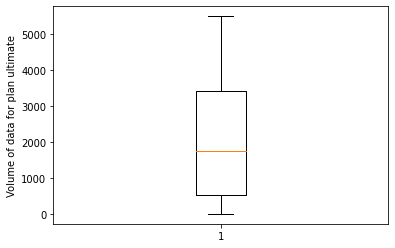

Boxplot for-data_ultimate_revised


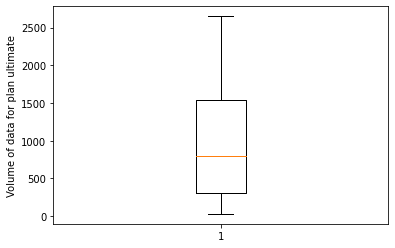

In [293]:
# Diagrama de cajas

for dataframe in revised_dataframes:      
        
    print(f"Boxplot for-{dataframe.name}")
    plt.figure()
    plt.boxplot(dataframe)
    plt.ylabel(f"Volume of {pivot.name} for plan {plan}")
    plt.show()

**Conclusiones intermedias EDA**

1. Se aprecia que el plan surf genera un mayor volumen de consumo en todos los rubros (cantidad de llamadas, minutos de las mismas, SMSs, y datos).

## Prueba de hipótesis<a id='#hypotheses'></a>

En esta sección se evaluarán las siguientes hipotesis:
    
1. El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
2. El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.

*Elminación de valores extremos de ingresos*

In [294]:
# Genera tablas con información mensual para analizar la cantidad de minutos, 
# SMS y volumen de datos por tipo de plan para el análisis de anomalías

def analysis_df_hypotesis(dataframe):
    
    """"
    
    Genera tablas para analizar minutos, SMS y volumen de datos por tipo de plan
    
    """
    pivot_to_dataframe = dataframe.reset_index().rename_axis(None, axis=1) #convierte la tabla pivot en un dataframe  
    result = pd.merge(pivot_to_dataframe, users, on="user_id") #une las tablas en base a la columna "user_id" 
    result[[1,2,3,4,5,6,7,8,9,10,11,12]] = (result[[1,2,3,4,5,6,7,8,9,10,11,12]].fillna(0).apply(np.ceil)) #preprocesa el dataframe
    result = result.groupby(["user_id"]).agg({ #agrupa por número de usuario, suma los valores de las columnas 1 a 12 y coloca la ubicación de usuario
                       1: sum,
                       2: sum,      
                       3: sum,
                       4: sum,      
                       5: sum,
                       6: sum, 
                       7: sum, 
                       8: sum, 
                       9: sum, 
                       10: sum, 
                       11: sum,  
                       12: sum})   
    return result

In [295]:
monthly_revenue_ultimate[monthly_revenue_ultimate['user_id']=='1006']

,user_id,state,plan,1,2,3,4,5,6,7,8,9,10,11,12
1,1006,CA,ultimate,70,70,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,84.0


In [296]:
# Genera matrices para el análisis de anomalías

monthly_revenue_surf_anomaly = analysis_df_hypotesis(monthly_revenue_surf)
monthly_revenue_ultimate_anomaly = analysis_df_hypotesis(monthly_revenue_ultimate)
monthly_revenue_anomaly = analysis_df_hypotesis(monthly_minutes)

In [297]:
# Genera nuevos dataframes sin anomalías

monthly_revenue_surf_anomaly_revised = anomaly_handling(monthly_revenue_surf_anomaly)
monthly_revenue_ultimate_anomaly_revised = anomaly_handling(monthly_revenue_ultimate_anomaly)
monthly_revenue_revised = anomaly_handling(monthly_revenue_anomaly)

**Prueba 1: El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere**

* h0: El ingreso promedio de los usuarios de las tarifas Ultimate y Surf es igual. 
* h1: El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.

In [298]:
# Prueba 1

sample_surf = monthly_revenue_surf_anomaly_revised.stack()
sample_ultimate = monthly_revenue_ultimate_anomaly_revised.stack()

alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(sample_surf, sample_ultimate)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")


p-value:  0.0
Rechazamos la hipótesis nula


**Conclusión prueba 1** 

* En base a los resultados de la prueba 1, se rechaza la hipótesis nula y se concluye que existe una alta probabilidad de que las medias de los ingresos de los planes "surf" y "ultimate" difieran.

**Prueba 2: El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones**
    
* ho: El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es igual al de los usuarios de otras regiones
* h1: El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones

In [299]:
# Prepara las matrices del área de Nueva York-New Jersey y del resto del pais 

monthly_revenue_revised = monthly_revenue_revised.reset_index()
monthly_revenue_revised = pd.merge(monthly_revenue_revised,users,on = "user_id")
monthly_revenue_revised["state"] = monthly_revenue_revised["state"].str.strip()
monthly_revenue_revised_ny_nj = monthly_revenue_revised[monthly_revenue_revised['state'] == 'NY'] #incluye la zona de New York 
monthly_revenue_revised_not_ny_nj = monthly_revenue_revised[monthly_revenue_revised['state'] != 'NY']

In [300]:
# Genera matrices para el análisis de anomalías

monthly_revenue_revised_ny_nj_anomaly = analysis_df_hypotesis(monthly_revenue_revised_ny_nj)
monthly_revenue_revised_not_ny_nj_anomaly = analysis_df_hypotesis(monthly_revenue_revised_not_ny_nj)

In [301]:
# Genera nuevos dataframes sin anomalías

monthly_revenue_revised_ny_nj_anomaly = anomaly_handling(monthly_revenue_revised_ny_nj_anomaly)
monthly_revenue_revised_not_ny_nj_anomaly = anomaly_handling(monthly_revenue_revised_not_ny_nj_anomaly)

In [302]:
# Prueba 2

sample_ny_nj = monthly_revenue_revised_ny_nj_anomaly.stack()
sample_not_ny_nj = monthly_revenue_revised_not_ny_nj_anomaly.stack()

alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(sample_ny_nj, sample_not_ny_nj)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  0.001470507197338757
Rechazamos la hipótesis nula


**Conclusión prueba 2**

En base a los resultados de la prueba 2, se rechaza la hipótesis nula y se concluye que existe una alta probabilidad de que las medias de los ingresos de las áreas de New York-New Jersey y del resto del país difieran.

## Conclusiones <a id='#end'></a>

1. El preprocesamiento requirió en primer lugar del cambio de tipo de datos (a "string", formatos de fecha, etc.). Adicionalmente, los pasos clave para este procesamiento fueron el aplicar los métodos "merge" y "concatenate" para unir tablas. Finalmente, un paso importante para el preprocesamiento fue el uso de expresiones regulares para extraer los datos de ubicación ("state") de los usuarios.

2. En base al análisis exploratorio de datos, se aprecia de las muestras que el plan "surf" genera un mayor volumen de consumo en todos los rubros (cantidad de llamadas, minutos de las mismas, SMSs, y datos).

3. En base a los resultados de la prueba 1, se rechaza la hipótesis nula y se concluye que existe una alta probabilidad de que las medias de los ingresos de los planes "surf" y "ultimate" difieran.

4. En base a los resultados de la prueba 2, se rechaza la hipótesis nula y se concluye que existe una alta probabilidad de que las medias de los ingresos de las áreas de New York-New Jersey y del resto del país difieran.